# Notebook for the Alento (site nb2) data processing

- 🔨 Data acquisition: G. Cassiani
- Notebook Author: B. Mary

### Steps to reproduce
- import all libraries
- import raw merged data 
- create resipy project 3d
- import electrode geometry
- create thetra mesh
- invert
- show results 

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  6 09:22:55 2021

@author: ben
"""
# import resipy and other useful libraries
# -----------------------------------------------------------------------------
#get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [16]:
sys.path.append((os.path.relpath('../src'))) # add here the relative path of the API folder
from resipy import Project
dir_simu = './background_time'
k = Project(dirname=dir_simu, typ='R3t')
k.setTitle('Salorno_site2')

Working directory is: /home/ben/Documents/Ongoing/Salorno/background_time


# Import RAW data
### Raw file: file120data.dat

# Set reciprocal filter to 10%

In [18]:
# create survey
# -----------------------------------------------------------------------------
k.createSurvey('./file120data.csv', ftype='Syscal') # read the survey file
per_rec = 10
k.filterRecip(index=-1, percent=per_rec)

Survey.filterDefault: 1167 duplicates removed.

Survey.filterDefault: 2 measurements with A or B == M or N

filterData: 2 / 19221 quadrupoles removed.
18558/19219 reciprocal measurements found.
6512 measurements error > 20 %
18558/19219 reciprocal measurements found.
6512 measurements error > 20 %
0 measurements with greater than 10.0% reciprocal error removed!
9542 measurements with greater than 10.0% reciprocal error removed!


9542

# Create boreholes geometry

### raw file: coordinatepozzilaghetti.txt

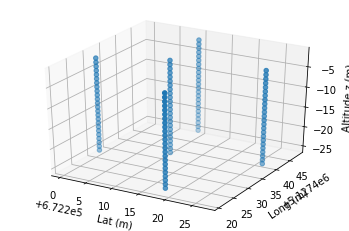

,x,y,z,label,buried
0,672200.2852,5.127431e+06,-25.0,1,True
1,672200.2852,5.127431e+06,-24.0,2,True
2,672200.2852,5.127431e+06,-23.0,3,True
3,672200.2852,5.127431e+06,-22.0,4,True
4,672200.2852,5.127431e+06,-21.0,5,True


In [21]:
# create boreholes geometry
# -----------------------------------------------------------------------------
nb_elecs_bor = 24
elecs_spacing = 1
offset = 1
asc_bor = np.arange(-nb_elecs_bor*elecs_spacing-offset,0-offset)
des_bor = np.flip(asc_bor)
elecs_z = np.hstack([asc_bor,des_bor,des_bor,des_bor,des_bor])

elecs = []
label = []

# lat/long of the electrodes
# -----------------------------------------------------------------------------
pozzi_coords = pd.read_csv('./coordinatepozzilaghetti.txt', header='infer')
i=1
for index, row in pozzi_coords.iterrows():
    for ne in range(len(asc_bor)):
        elecs.append([row[1],row[2],row[3]])
        # print([str(1),str((ne+1)*(index+1))])
        # label.append(' '.join([str(index+1),str(ne+1)]))
        # label.append(' '.join([str(1),str(i)]))
        label.append(' '.join([str(i)]))
        i +=1

# correct for altitude
# -----------------------------------------------------------------------------
for ze in enumerate(elecs_z):
    # elecs[ze[0]][2] +=  ze[1]
    elecs[ze[0]][2] =  ze[1]

elecs = np.vstack(elecs)
max_elecs= max(elecs[:,2])

# buried flag for upper surface electrode is False!
# -----------------------------------------------------------------------------
buried = []
for e in elecs:
    if e[2] == max_elecs:
        buried.append(False)
    else:
        buried.append(True)
            
# plot electrode positions
# -----------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(elecs[:,0], elecs[:,1], elecs[:,2], marker='o')

ax.set_xlabel('Lat (m)')
ax.set_ylabel('Long (m)')
ax.set_zlabel('Altitude z (m)')

plt.show()

# electrode positions to dataframe
# -----------------------------------------------------------------------------
elecs_df = pd.DataFrame(elecs,columns=['x', 'y', 'z'])
elecs_df['label'] = label
elecs_df['buried'] = buried

elecs_df.to_csv('./elecs120data.csv', index=False)
elecs_df.head()

# Create mesh (using gmsh)
## refine is set to 1

Creating tetrahedral mesh...refining...done (80896 elements)


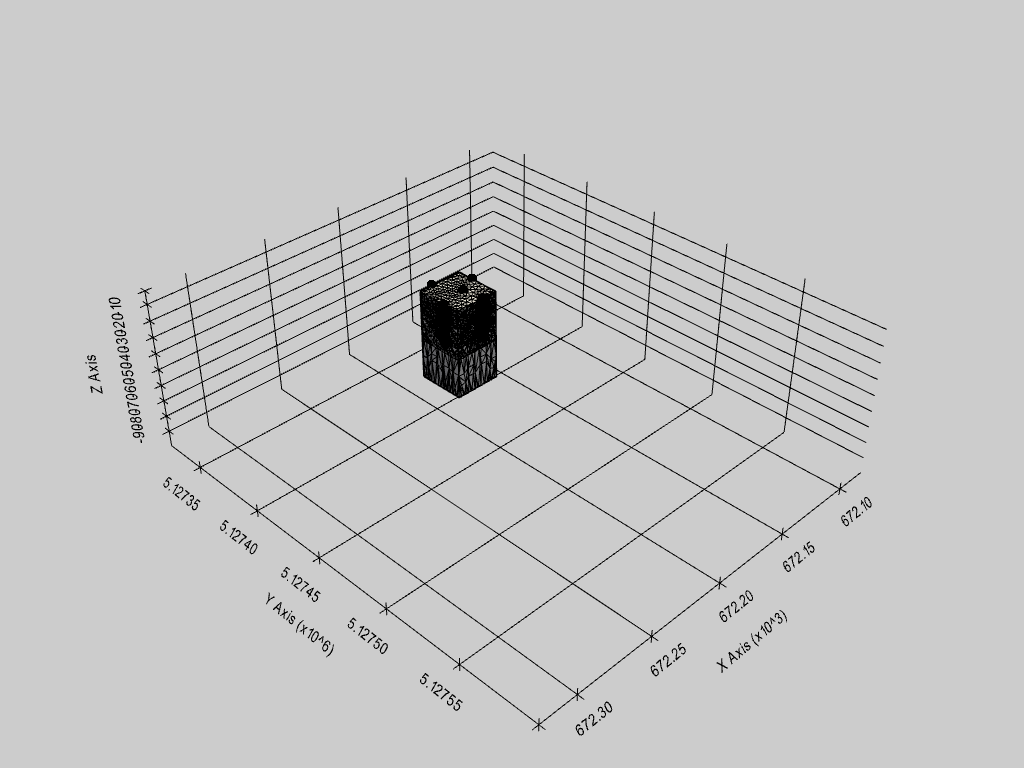

In [22]:
k.setElec(elecs_df)
k.createMesh(typ="tetra", 
             refine=1)
k.showMesh()

             # cl_factor=8.00, 
             # cln_factor=100.00,

In [23]:
# import raw data and reshape for resipy 
# -----------------------------------------------------------------------------
data = np.loadtxt('./file120data.dat')

data_df = pd.DataFrame(data[:,[0,1,2,3,8,9]], columns=['Spa.1','Spa.2','Spa.3','Spa.4','Vp' ,'In'])
data_df['Spa.1'] = data_df['Spa.1'].astype(int)
data_df['Spa.2'] =data_df['Spa.2'].astype(int)
data_df['Spa.3'] =data_df['Spa.3'].astype(int)
data_df['Spa.4'] = data_df['Spa.4'].astype(int)

data_df['dev'] = np.zeros(len(data_df['Spa.1']))
data_df.to_csv('./file120data.csv', index=False)

data_df.head()

,Spa.1,Spa.2,Spa.3,Spa.4,Vp,In,dev
0,1,4,2,5,6527.037,617.326,0.0
1,1,4,5,8,-3688.600,617.326,0.0
2,1,4,8,11,-468.632,617.326,0.0
3,1,4,11,14,-5756.949,617.326,0.0
4,1,4,14,17,5341.710,617.326,0.0


# Inversion

In [24]:
# inversion
# -----------------------------------------------------------------------------
k.param['num_xy_poly'] = 0
k.param['z_min'] = max(elecs_df['z'])
k.param['z_max'] = min(elecs_df['z'])
k.param['data_type'] = 1 # using log of resistitivy
k.err = False # if we want to use the error from the error models fitted before
k.param['a_wgt'] = 0.01
k.param['b_wgt'] = per_rec/100 #0.05
k.invert() # this will do the inversion
# k.saveData(MainPath)


Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------


 >> R 3 t     E R T    M o d e l    v 2.31 <<

 >> Date: 06-12-2021
 >> Salorno_site2                                                                   
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> A d v a n c e d   M e s h   I n p u t <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from res0.dat                                                                        

 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<

 >> Memory estimates:
    For   1000 measurements the memory needed is:          0.674 Gb
    For   2000 measurements the memory needed is:          1.322 Gb
    For   5000 measurements the memory needed is:          3.26

KeyboardInterrupt: 

forrtl: severe (172): Program Exception - exception code = 0x13a (314)
Image              PC                Routine            Line        Source             
R3t.exe            00000001400189D7  Unknown               Unknown  Unknown


# Results

In [ ]:
k.showResults(attr='Resistivity(log10)', 
              sens=True, 
              contour=True, 
              use_pyvista=True,
              color_map='jet')
#,             xlim=[0,100],ylim=[-50,50],zlim=[-100,0])

k.showResults(attr='Sensitivity_map(log10)', 
              sens=True, 
              contour=True, 
              use_pyvista=True,pvshow=True) 

In [ ]:
# save project
# -----------------------------------------------------------------------------
k.saveProject('Salorno_2')

forrtl: severe (172): Program Exception - exception code = 0x13a (314)
Image              PC                Routine            Line        Source             
R3t.exe            0000000140018338  Unknown               Unknown  Unknown
